In [1]:
import pandas as pd
import numpy as np
import os
import logging
import time

import parse_genet
import sys
import getopt

import vi

import importlib

import simulate
import torch
import matplotlib.pyplot as plt
import pyro.distributions as dist

import scipy.stats

In [13]:
## add annotations part from simulate.py
def simulate_sumstats(ld_blk, blk_size, n_gwas, p, prop_nz = 0.2, beta_sd = 0.1, sigma_noise = 1., anno_path= False): 
    sigma_over_sqrt_n = sigma_noise / torch.sqrt(torch.tensor(n_gwas))
    nz = torch.rand(p) < prop_nz ## filter the snp with p threshold < prop_nz ## creating perfect annotation
    ## nz: the perfect annotaion (1 for causal, 0 for not); ## should add some noise here too
    beta_true = torch.where(nz, beta_sd * torch.randn(p), torch.zeros(p)) ## torch.randn = random normal distribution

    #annotations = torch.stack([torch.ones(p),nz,torch.randn(p)]).T # intercept, useful annotation, random annotation
    ### reading annotations
    chrom = 22
    anno_files = anno_path.split(',') if ',' in anno_file else [anno_path]
    anno_list = []
    for anno in anno_files:
        anno_path = anno + f'{chrom}.annot.gz'
        if not os.path.exists(anno_path):
            raise IOError(f'Cannot find annotation file {anno}')
        anno_list.append(anno_path)
    print("Reading annotations from %d file(s)... "%len(anno_list))
    
    ## parsing multiple annoation files
    if len(anno_list) == 1:
        anno_df =pd.read_csv(anno_list[0], compression='gzip',sep = '\t') 
    else:
        anno_df_list = [pd.read_csv(file, compression='gzip',sep='\t') for file in anno_list]
        columns_match = all(anno_df_list[0][['CHR', 'SNP', 'BP', 'A1', 'A2']].equals(df[['CHR', 'SNP', 'BP', 'A1', 'A2']]) for df in anno_df_list[1:])
        if columns_match:
            anno_df = pd.concat(anno_df_list, axis=1)
            anno_df = anno_df.loc[:, ~anno_df.columns.duplicated()]
        else:
            raise IOError("Failed to merge annotations")
    print("Successfully loaded %d annotations for %d SNPs \n" %(anno_df.shape[1]-5, anno_df.shape[0]))
    
    anno_merge = sst_dict[['SNP','A1','A2']].merge(anno_df, on = 'SNP', suffixes=('', '_y')) 
    print('Total of %d SNPs after merging with sst \n'%(anno_merge.shape[0]))
    
    ## flipping annotations if A1,A2 is opposite with the sst
    flipping = anno_merge.loc[anno_merge["A1"] == anno_merge['A2_y']]
    if flipping.shape[0] > 0 :
        print('Flipping annotaions for %d rows'% flipping.shape[0])
        for col_index in range(7, anno_merge.shape[1]):
            anno_merge.loc[anno_merge["A1"] == anno_merge['A2_y'], anno_merge.columns[col_index]] = -anno_merge.iloc[:, col_index]

    anno_merge = anno_merge.drop(["A1_y", 'A2_y'], axis=1)
    annotations = torch.cat((torch.ones((anno_merge.shape[0],1)),torch.tensor(anno_merge.iloc[:,5:].values)), dim=1)
    
    beta_mrg = torch.zeros(p)
    mm = 0
    for kk in range(len(ld_blk)):
        idx_blk = torch.arange(mm,mm+blk_size[kk])
        ld_torch = torch.tensor(ld_blk[kk], dtype = torch.float)
        L, V = torch.linalg.eigh(ld_torch)
        L[L < 0.] = 0.

        beta_mrg[idx_blk] = ld_torch @ beta_true[idx_blk] + sigma_over_sqrt_n * (V @ torch.diag(L.sqrt())) @ torch.randn(blk_size[kk])
        #ld_torch @ beta_true[idx_blk], 
        # covariance_matrix = ld_torch * sigma_over_sqrt_n**2).rsample()
        mm += blk_size[kk]

    return beta_true, beta_mrg, annotations


In [15]:
chrom=22
t0 = time.time()
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000,
    "anno" : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr'
}

ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_ukbb_hm3')
ref_df = ref_df[ref_df.CHR == chrom]
vld_df = parse_genet.parse_bim(param_dict['bim_prefix'] + ".bim")
vld_df = vld_df[vld_df.CHR == chrom]
sst_dict = parse_genet.parse_sumstats(ref_df, vld_df, param_dict['sst_file'], param_dict['n_gwas'])
ld_blk, ld_blk_sym, blk_size = parse_genet.parse_ldblk(param_dict['ref_dir'], sst_dict, chrom)                                                                                                                                                                                 
print("There are %d ld_blk" %(len(ld_blk)))

beta_true, beta_mrg, annotations = simulate_sumstats(ld_blk, blk_size, param_dict['n_gwas'], p = len(sst_dict), anno_path = bl_anno)

print('Done in %0.2f seconds'%(time.time() - t0))

... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/sumstats.txt ...
... 991 common SNPs in the reference, sumstats, and validation set ...
... parse reference LD on chromosome 22 ...
there are 4 ld_blk
Reading annotations from 3 file(s)... 
Successfully loaded 28 annotations for 271699 SNPs 

Total of 991 SNPs after merging with sst 

Flipping annotaions for 756 rows
Done in 6.95 seconds


In [6]:
ref_df


,index,CHR,SNP,BP,A1,A2,MAF
0,1101065,22,rs7287144,16886873,G,A,0.27220
1,1101066,22,rs5748662,16892858,A,G,0.27120
2,1101067,22,rs5747620,17032698,C,T,0.40470
3,1101068,22,rs9605903,17054720,C,T,0.27760
4,1101069,22,rs5747940,17056415,T,C,0.49070
...,...,...,...,...,...,...,...
16355,1117420,22,rs2285395,51178090,A,G,0.05199
16356,1117421,22,rs13056621,51181759,A,G,0.13070
16357,1117422,22,rs3888396,51211392,C,T,0.10210
16358,1117423,22,rs2238837,51212875,C,A,0.30240


## parse annotations

In [4]:
bl_anno='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr'
deepsea='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/deepsea/deepsea_high_h2_chr'
enformer='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/enformer/enformer_high_h2_chr'

anno_file = bl_anno+','+deepsea+','+enformer

anno_torch = parse_genet.parse_anno(anno_file, sst_dict,22)


... parse annotations ...
Reading annotations from 3 file(s)... 
Successfully loaded 28 annotations for 271699 SNPs 

Total of 991 SNPs after merging with sst 

Flipping annotaions for 756 rows
Done in 1.86 seconds


In [65]:
## simplified version
anno_file = bl_anno+','+deepsea+','+enformer
anno_files = anno_file.split(',') if ',' in anno_file else [anno_file]

anno_list = []
for anno in anno_files:
    anno_path = anno + f'{chrom}.annot.gz'
    if not os.path.exists(anno_path):
        raise IOError(f'Cannot find annotation file {anno}')
    anno_list.append(anno_path)

print(anno_list)
   
    
if len(anno_list) == 1:
    anno_df =pd.read_csv(anno_list[0], compression='gzip',sep = '\t') 
else:
    anno_df_list = [pd.read_csv(file, compression='gzip',sep='\t') for file in anno_list]
    
    columns_match = all(anno_df_list[0][['CHR', 'SNP', 'BP', 'A1', 'A2']].equals(df[['CHR', 'SNP', 'BP', 'A1', 'A2']]) for df in anno_df_list[1:])
    
    if columns_match:
        anno_df = pd.concat(anno_df_list, axis=1)
        anno_df = anno_df.loc[:, ~anno_df.columns.duplicated()]
        
    else:
        raise IOError("Can't successfully merge annotations")
        
print("Successfully loaded %d annotations for %d SNPs" %(anno_df.shape[1]-5, anno_df.shape[0]))

Successfully loaded 28 annotations for 271699 SNPs


In [37]:
df_snps.iloc[:,5:10].values.ravel('K')

array([0., 0., 0., ..., 0., 0., 0.])

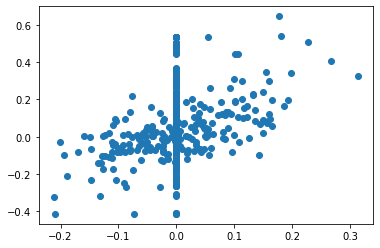

In [3]:
plt.scatter(beta_true, beta_mrg)

In [4]:
annotations

tensor([[ 1.0000,  0.0000, -1.5152],
        [ 1.0000,  1.0000,  0.7892],
        [ 1.0000,  0.0000, -0.3203],
        ...,
        [ 1.0000,  0.0000, -1.5114],
        [ 1.0000,  1.0000, -1.5003],
        [ 1.0000,  0.0000, -1.1544]])

def vi(
    sst_df, 
    n, 
    ld_blk, 
    blk_size, 
    device = "cpu",
    annotations = None,
    sigma_noise = None, 
    phi = None, 
    phi_as_prior = True,
    constrain_psi = True, 
    constrain_sigma = False,
    desired_min_eig = 1e-3, 
    **opt_kwargs
):

In [5]:
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000,
    'n_burnin': 500, 'thin': 5,'a': 1, 'b': 0.5, 'phi': None, 'chrom':22,
    "anno" : anno_torch
}


## vi 
logging.getLogger().setLevel(logging.INFO)
t0 = time.time()
vi_test = vi.vi( sst_dict, param_dict['n_gwas'], ld_blk, blk_size)        
logging.info('Done in %0.2f seconds'%(time.time() - t0))
#losses, beta, phi_est, stats = vi.vi(sst_dict, param_dict['n_gwas'], ld_blk, blk_size, device = device, annotations = None, max_iterations = param_dict['n_iter'], min_particles = 1, max_particles=4, desired_min_eig = 1e-3, min_iterations = 200, stall_window = 30, phi_as_prior = False, lr = 0.03, constrain_sigma = True)


... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 213 iterations. Increasing num_particles to 2.
Done after 37 iterations. Increasing num_particles to 4.
Done after 34 iterations. Increasing num_particles to 8.
Done after 33 iterations. Increasing num_particles to 16.


INFO:root:Done in 24.44 seconds


In [6]:
len(vi_test[0])

313

In [7]:
len(vi_test[1])  ## beta is per snp

991

In [8]:
vi_test[3].keys()

dict_keys(['sqrt_phi', 'sqrt_psi', 'sigma_noise', 'obs_0', 'obs_1', 'obs_2', 'obs_3', 'beta'])

In [12]:
vi_test[3]['beta'].keys()

dict_keys(['mean', 'std', '5%', '95%'])

In [13]:
len(vi_test[3]['beta']['mean'])

991